# Experiment with different classification algorithms

## Plan

### Step 1: Experiment with Different Classification Algorithms

We'll try several classification algorithms and compare their performance. Specifically, we'll experiment with:

- ExtraTreeClassifier
- QuadraticDiscriminantAnalysis
- LabelSpreading
- LabelPropagation
- Perceptron

### Step 2: Feature Engineering

We'll create interaction features to see if combining some of the features improves the model's performance.

## Set up

In [2]:
import pandas as pd
import joblib
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.tree import ExtraTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel, chi2

# Load the data
file_path = r"../data/clean/ACME-happinesSurvey2020.parquet"
data = pd.read_parquet(file_path)
target = 'Y'
data_melt = data.melt(id_vars=target, value_vars=data.columns)

## 1. Visualisualization of relationship between features and target

### 2.1 Plot correlations

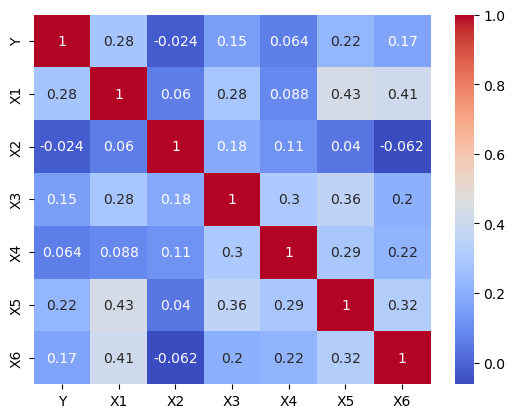

In [3]:
corr = data.corr()  # Calculate the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')  # Create a heatmap
plt.show()  # Show the plot

### 2.2 Plot relationships

C:\Users\Guill\AppData\Local\Temp\ipykernel_94256\2225255784.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(


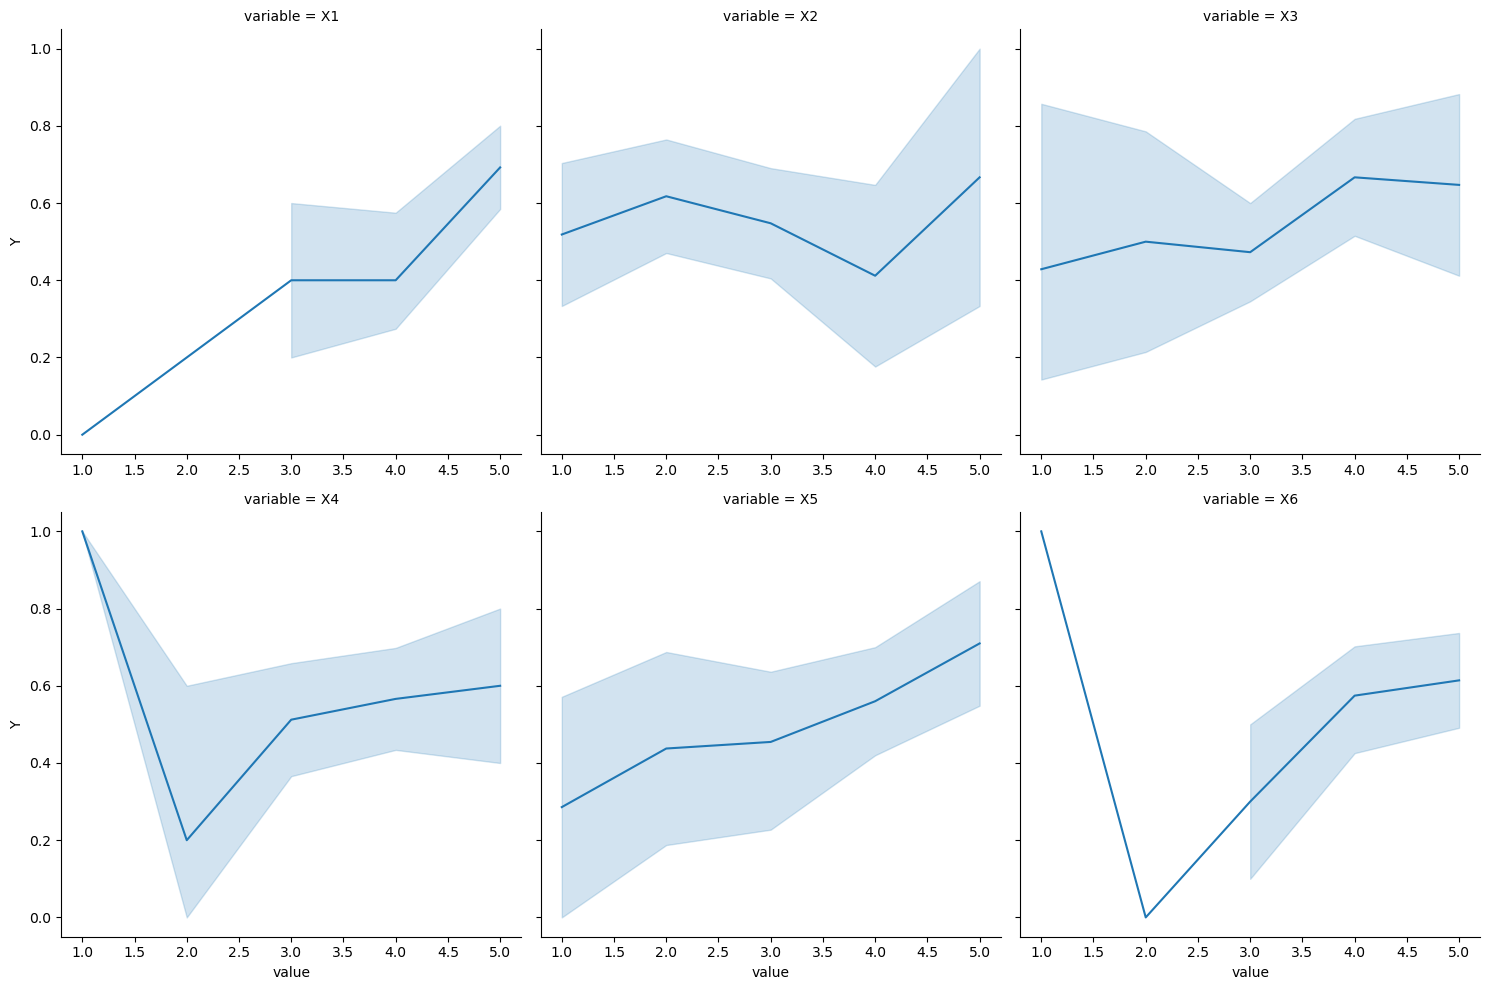

In [4]:
sns.relplot(
    x="value", y=target, col="variable", data=data_melt, facet_kws=dict(sharex=False),
    kind="line", palette="viridis", height=5, aspect=1,
    col_wrap=3

);

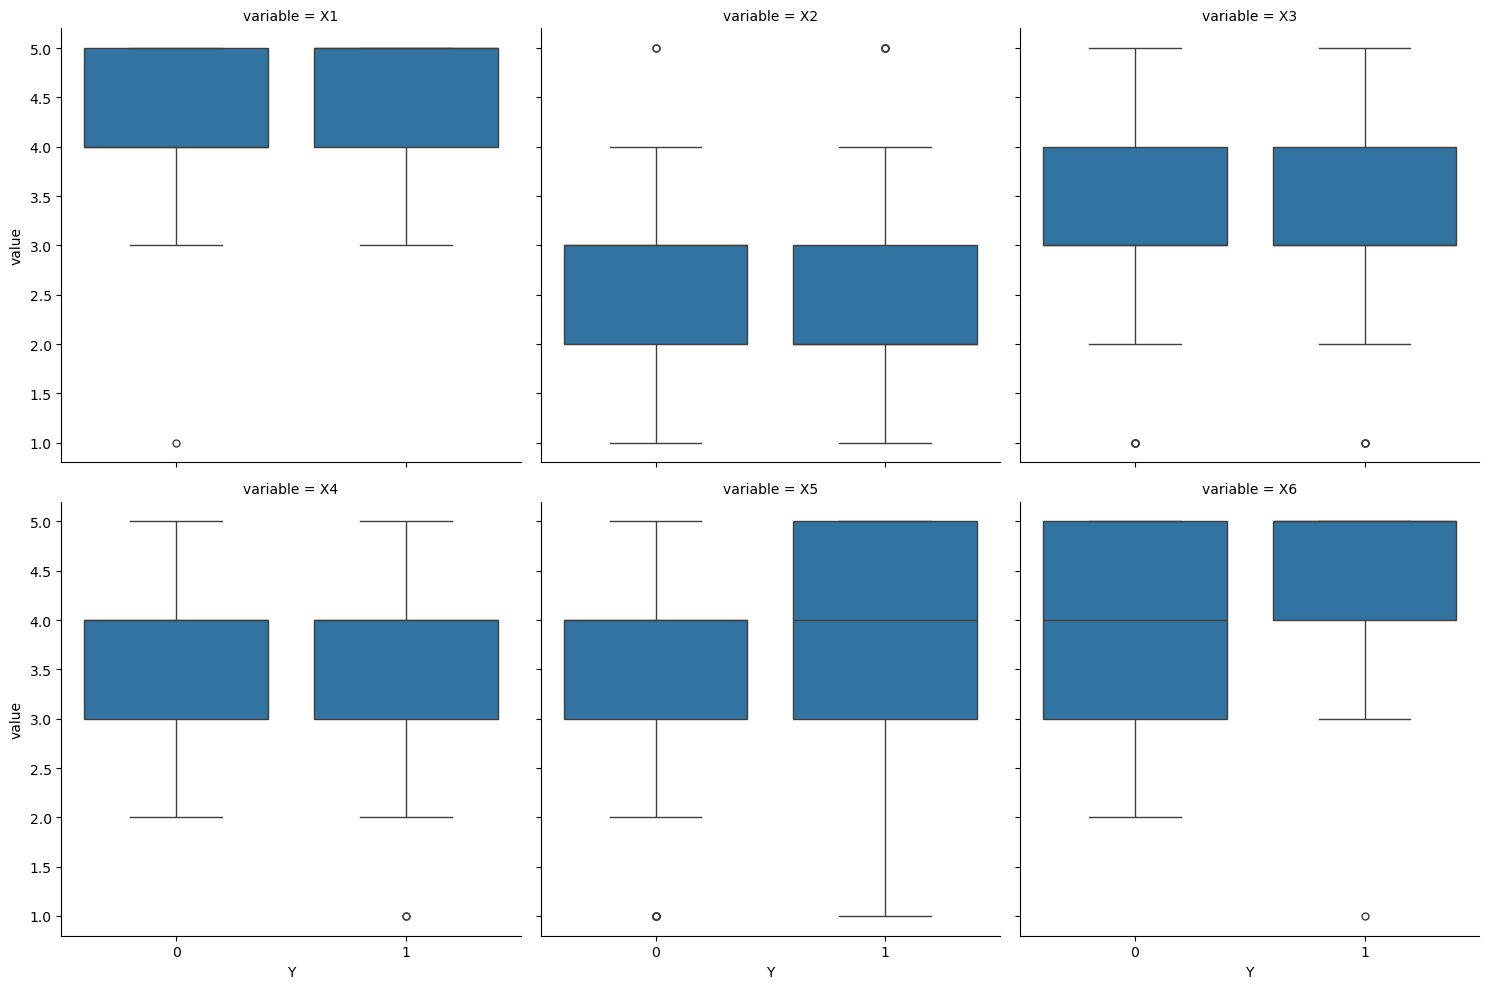

In [5]:
sns.catplot(x=target, y="value", col='variable', data=data_melt, kind="box", col_wrap=3);

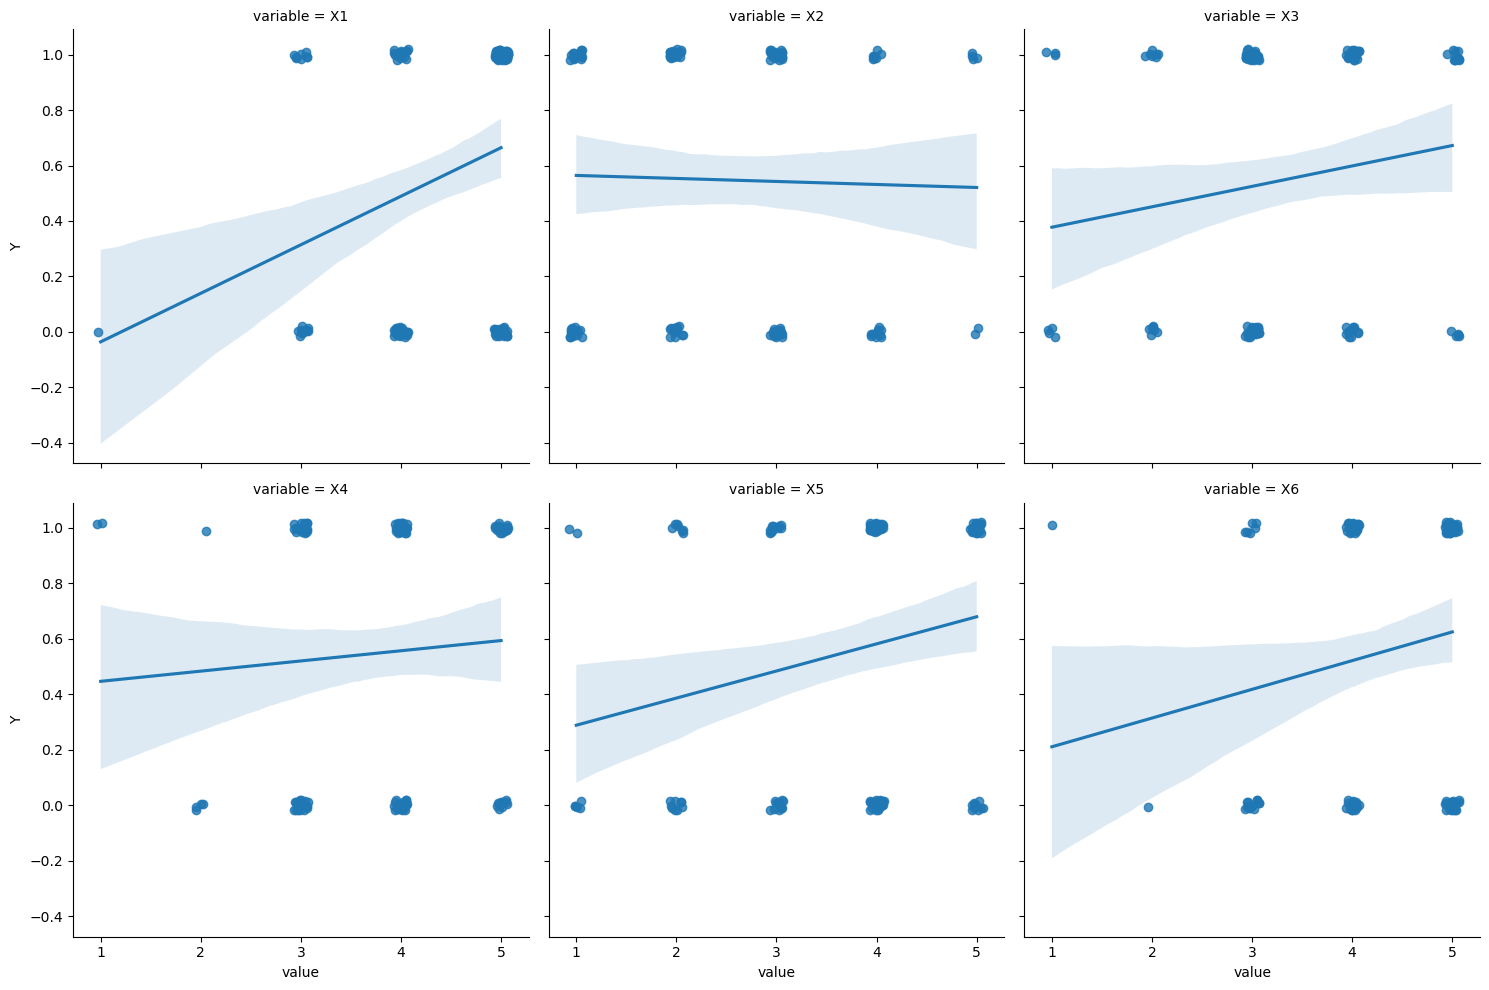

In [6]:
sns.lmplot(y=target, x="value", data=data_melt,
           col='variable', col_wrap=3,
           x_jitter=.07, y_jitter=.02, seed=42);

## 3. Modeling

#### 3.1 Split Data

In [7]:
# Separate features and target
y = data.pop('Y')
X = data

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Baseline experiment with Different Classification Algorithms

#### 3.2.1 Baseline models

In [8]:
# Define the models
models = {
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=42),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'LabelSpreading': LabelSpreading(),
    'LabelPropagation': LabelPropagation(),
    'Perceptron': Perceptron(random_state=42)
}

# Define the parameter grids for each model
param_grids = {
    'ExtraTreeClassifier': {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'QuadraticDiscriminantAnalysis': {
        'reg_param': [0.0, 0.1, 0.5, 1.0],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1]
    },
    'LabelSpreading': {
        'kernel': ['knn', 'rbf'],
        'gamma': [0.1, 0.5, 1, 5],
        'n_neighbors': [3, 5, 7, 9]
    },
    'LabelPropagation': {
        'kernel': ['knn', 'rbf'],
        'gamma': [0.1, 0.5, 1, 5],
        'n_neighbors': [3, 5, 7, 9]
    },
    'Perceptron': {
        'penalty': [None, 'l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'max_iter': [1000, 2000, 5000],
        'tol': [1e-4, 1e-3, 1e-2]
    }
}

# Define the scoring criteria
scoring = {'F1': make_scorer(f1_score), 'Recall': make_scorer(recall_score)}

# Perform hyperparameter tuning using RandomizedSearchCV for faster results
best_estimators = {}
best_scores = {}

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    search = RandomizedSearchCV(model, param_grid, scoring=scoring, refit='F1', n_jobs=-1, cv=5, random_state=42)
    search.fit(X_train, y_train)
    
    # Store the best estimator and best scores
    best_estimators[model_name] = search.best_estimator_
    best_scores[model_name] = search.best_score_

best_estimators, best_scores

({'ExtraTreeClassifier': ExtraTreeClassifier(criterion='log_loss', max_depth=30, min_samples_leaf=4,
                      min_samples_split=5, random_state=42),
  'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(reg_param=0.1, tol=0.001),
  'LabelSpreading': LabelSpreading(gamma=0.5, n_neighbors=9),
  'LabelPropagation': LabelPropagation(gamma=0.5, n_neighbors=9),
  'Perceptron': Perceptron(alpha=0.001, max_iter=5000, penalty='l2', random_state=42, tol=0.01)},
 {'ExtraTreeClassifier': 0.6165654004291776,
  'QuadraticDiscriminantAnalysis': 0.6731304347826087,
  'LabelSpreading': 0.7456172937596742,
  'LabelPropagation': 0.7088407369831173,
  'Perceptron': 0.6476958525345622})

### 3.3 Feature Engineering

#### 3.3.1  Feature Importances

In [9]:
# Initialize a dictionary to store feature importances using permutation importance
feature_importances = {}

# Loop through the best estimators
for model_name, model in best_estimators.items():
    if hasattr(model, 'feature_importances_'):
        # If the model has a feature_importances_ attribute
        feature_importances[model_name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # If the model has a coef_ attribute (for linear models)
        feature_importances[model_name] = model.coef_.flatten()
    else:
        print("Model does not have a feature_importances_ or coef_ attribute:", model_name)


# Convert the dictionary to a DataFrame
feature_importances_df = pd.DataFrame(feature_importances, index=X_train.columns)

# Display the DataFrame
feature_importances_df

Model does not have a feature_importances_ or coef_ attribute: QuadraticDiscriminantAnalysis
Model does not have a feature_importances_ or coef_ attribute: LabelSpreading
Model does not have a feature_importances_ or coef_ attribute: LabelPropagation


,ExtraTreeClassifier,Perceptron
X1,0.517217,11.513236
X2,0.000000,-8.305427
X3,0.034736,-1.506532
X4,0.000000,-4.534774
X5,0.056737,1.463188
X6,0.391310,-5.488321


In [10]:
# Initialize a dictionary to store feature importances using permutation importance
feature_importances_permutation = {}

# Loop through the best estimators
for model_name, model in best_estimators.items():
        # Calculate permutation importance
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importances_permutation[model_name] = result.importances_mean

        # Convert the dictionary to a DataFrame
        feature_importances_permutation_df = pd.DataFrame(feature_importances_permutation, index=X_train.columns)

# Display the DataFrame
feature_importances_permutation_df

,ExtraTreeClassifier,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,Perceptron
X1,0.130769,0.080769,1.153846e-02,0.026923,0.030769
X2,0.000000,0.130769,-6.153846e-02,-0.030769,-0.011538
X3,0.000000,0.007692,-2.692308e-02,-0.015385,-0.015385
X4,0.000000,0.011538,-1.110223e-17,0.042308,-0.026923
X5,0.211538,-0.015385,-1.538462e-02,-0.003846,-0.003846
X6,-0.023077,0.046154,3.846154e-02,0.069231,-0.038462


### Permutation importance Interpretation:

- **X1** stands out as the most important feature overall, with a positive contribution, particularly in tree-based models.
- **X2** and **X6** seem to have a negative impact across the models, indicating that they might not be as useful and could potentially be candidates for removal or further investigation.
- **X3** and **X5** have minor positive impacts, but their overall influence is relatively low compared to X1.
- **X4** seems to have a negligible impact overall, with a slight negative influence.

> **Negative Coefficient** (in models like Logistic Regression or SVM): Indicates a negative effect on the target variable.
>
> **Negative Importance** (especially in permutation importance): Could indicate the feature is harmful or irrelevant to the model’s performance.

### 4: Feature Engineering: Create interaction features

In [11]:
# Feature Engineering: Create interaction features
poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
column_names_poly=poly.get_feature_names_out(X_train.columns)

# Train and evaluate each model with interaction features
results_poly = {}
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results_poly[name] = (accuracy, report)

# Print results for models with interaction features
for model_name, (accuracy, report) in results_poly.items():
    print(f"Model with Interaction Features: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("="*60)

Model with Interaction Features: ExtraTreeClassifier
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.55      0.55      0.55        11

    accuracy                           0.62        26
   macro avg       0.61      0.61      0.61        26
weighted avg       0.62      0.62      0.62        26

Model with Interaction Features: QuadraticDiscriminantAnalysis
Accuracy: 0.6538461538461539
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.58      0.64      0.61        11

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.66      0.65      0.66        26

Model with Interaction Features: LabelSpreading
Accuracy: 0.6923076923076923
Classification Report:
              precision   

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


## 5: Feature Selection

#### 5.1 Permutation feature importance with interactions

In [12]:
# Initialize a dictionary to store the permutation importance
permutation_importances_poly = {}

# Loop through each model and calculate permutation importance
for model_name, model in models.items():
    # Calculate the permutation importance
    result = permutation_importance(
        model, X_test_poly, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # Store the importance in the dictionary
    permutation_importances_poly[model_name] = result.importances_mean

# Create a DataFrame to organize and display the results
permutation_importances_poly_df = pd.DataFrame(permutation_importances_poly, index=column_names_poly)

# Reorder the columns to match the desired order
permutation_importances_poly_df = permutation_importances_poly_df[[
    'ExtraTreeClassifier', 'QuadraticDiscriminantAnalysis', 'LabelSpreading', 'LabelPropagation', 'Perceptron'
]]

# Add the sum and average of the importances across models
permutation_importances_poly_df = permutation_importances_poly_df.assign(
    sum_tree=lambda x: x.iloc[:, 2:4].sum(axis=1),  # Sum of tree-based models (RandomForest and GradientBoosting)
    avg_tree=lambda x: x.iloc[:, 2:4].mean(axis=1),  # Average of tree-based models (RandomForest and GradientBoosting)
    avg_linear=lambda x: x.iloc[:, 0:2].mean(axis=1)  # Average of linear models (LogisticRegression and SVM)
).sort_values('avg_tree', ascending=False)

permutation_importances_poly_df

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


,ExtraTreeClassifier,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,Perceptron,sum_tree,avg_tree,avg_linear
X3^3,0.0,1.307692e-01,0.123077,0.123077,0.019231,0.246154,0.123077,6.538462e-02
X3 X6^2,0.0,8.461538e-02,0.123077,0.123077,-0.003846,0.246154,0.123077,4.230769e-02
X2 X5 X6,0.0,9.615385e-02,0.119231,0.119231,0.034615,0.238462,0.119231,4.807692e-02
X3^2 X6,0.0,7.692308e-02,0.119231,0.119231,0.019231,0.238462,0.119231,3.846154e-02
X2 X3 X5,0.0,1.038462e-01,0.115385,0.115385,0.034615,0.230769,0.115385,5.192308e-02
...,...,...,...,...,...,...,...,...
X6,0.0,1.923077e-02,0.000000,0.000000,0.000000,0.000000,0.000000,9.615385e-03
X5,0.0,1.038462e-01,0.000000,0.000000,0.000000,0.000000,0.000000,5.192308e-02
X4,0.0,1.110223e-17,0.000000,0.000000,0.000000,0.000000,0.000000,5.551115e-18
X3,0.0,3.076923e-02,0.000000,0.000000,0.000000,0.000000,0.000000,1.538462e-02


In [13]:
# Display the filtered DataFrame
df_train_poly = pd.DataFrame(X_train_poly,
                columns=column_names_poly,
                index=X_train.index
                )

df_test_poly = pd.DataFrame(X_test_poly,
            columns=column_names_poly,
            index=X_test.index
            )

#### 3.2 Feature Selection with different methods

- **Recursive Feature Elimination (RFE)**: We'll use RFE to select the most relevant features by recursively considering smaller sets of features and ranking them based on their importance.
- **Feature Importance from Tree-Based Models**: Tree-based models like Random Forest or XGBoost can provide feature importance scores that we can use to select a subset of the most important features.

##### A. Recursive Feature Elimination (RFE)

We'll use RFE with one of the classifiers, such as Logistic Regression or Random Forest, to select the most important features.

In [14]:
# Initialize Logistic Regression
lr = LogisticRegression(max_iter=10_000, random_state=42)

# Apply RFE
rfe = RFE(estimator=lr, n_features_to_select=10, step=1)
rfe.fit(df_train_poly, y_train)

# Get the support and ranking of the features
rfe_support = rfe.support_
rfe_ranking = rfe.ranking_

# Create a DataFrame with the feature names and their RFE ranking
rfe_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'RFE Ranking': rfe_ranking
})

# Filter the DataFrame to show only the selected features (those with RFE ranking = 1)
s_RFE_selected = rfe_df[rfe_support].set_index('Feature')

# Display the DataFrame with selected features and their rankings
display(s_RFE_selected)


,RFE Ranking
Feature,
X1 X3,1
X1 X6,1
X3 X4,1
X3 X5,1
X5 X6,1
X6^2,1
X1^2 X3,1
X1 X3 X6,1
X3 X6^2,1


##### **B. Chi2**

Using Chi2 for feature selection

In [15]:
# Assuming df_train_poly and y_train are your features and labels
chi2_scores, p_values = chi2(df_train_poly, y_train)

# Create a DataFrame to display Chi-square scores
chi2_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
})

# Sort the DataFrame by the Chi2 score in descending order
chi2_df = chi2_df.sort_values(by='Chi2 Score', ascending=False).iloc[:10]

# Display the Chi2 scores
print(chi2_df)

     Feature  Chi2 Score       p-value
27      X1^3  181.342284  2.468034e-41
31   X1^2 X5  134.269644  4.769711e-31
32   X1^2 X6  115.960373  4.848892e-27
29   X1^2 X3   97.628480  5.047274e-23
45   X1 X5^2   85.760104  2.031436e-20
30   X1^2 X4   79.458374  4.924931e-19
47   X1 X6^2   79.398694  5.075965e-19
46  X1 X5 X6   78.167134  9.468080e-19
41  X1 X3 X6   68.053996  1.590791e-16
40  X1 X3 X5   66.803243  3.000042e-16


##### SelectFromModel

In [16]:
# Train a RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(df_train_poly, y_train)

# Use SelectFromModel to select features
selector = SelectFromModel(rf, threshold='mean', max_features=10)  # You can adjust the threshold as needed
selector.fit(df_train_poly, y_train)

# Get the selected features
selected_features = df_train_poly.columns[(selector.get_support())]

# Create a DataFrame to show selected features
selected_features_df = pd.DataFrame({
    'Feature': selected_features
})

# Display the selected features
print(selected_features_df)

    Feature
0      X1^2
1     X1 X6
2  X1 X2 X3
3  X1 X2 X4
4   X1 X6^2
5   X2^2 X4
6  X2 X3 X5
7  X2 X3 X6
8  X2 X4 X6
9  X2 X5 X6


##### mutual_info_classif

In [17]:
# Calculate the mutual information for each feature in the training set
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(df_train_poly, y_train, random_state=42)

# Create a DataFrame to display the mutual information scores
mutual_info_s = pd.Series(
    data = mutual_info,
    index = df_train_poly.columns
).rename('Mutual Information')
mutual_info_s[mutual_info_s>0].sort_index(ascending=False)

X6^2        0.004682
X6          0.002619
X5^3        0.070087
X5^2 X6     0.015048
X5^2        0.006115
X5 X6^2     0.042427
X5          0.039205
X4^3        0.008369
X4 X6       0.003306
X4 X5 X6    0.005952
X3^2 X6     0.011375
X3 X6       0.041743
X2^3        0.050947
X2^2 X5     0.124726
X2^2 X4     0.029679
X2^2 X3     0.016954
X2^2        0.094450
X2 X6^2     0.051135
X2 X5^2     0.093753
X2 X5 X6    0.002376
X2 X4^2     0.014319
X2 X4 X5    0.079829
X2 X3 X4    0.017162
X2          0.019743
X1^3        0.069007
X1^2 X6     0.054116
X1^2 X5     0.090581
X1^2 X4     0.017681
X1^2 X3     0.157588
X1^2 X2     0.027533
X1^2        0.073667
X1 X6^2     0.119850
X1 X6       0.074999
X1 X5 X6    0.023279
X1 X5       0.086234
X1 X4^2     0.028810
X1 X4 X5    0.067758
X1 X3^2     0.038430
X1 X3 X4    0.062922
X1 X3       0.098925
X1 X2^2     0.056341
X1 X2 X6    0.031171
X1 X2 X5    0.012670
X1 X2       0.049244
X1          0.048744
Name: Mutual Information, dtype: float64

##### SequentialFeatureSelector

In [18]:
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(
    estimator=lr,
    n_features_to_select=10,
    direction='forward',
    cv=5
)

# Fit the SFS to the training data
sfs.fit(df_train_poly, y_train)

# Get the selected feature indices
sfs_support = sfs.get_support()

# Create a DataFrame with the selected features
sfs_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'SFS Support': sfs_support
})

# Filter the DataFrame to show only the selected features
sfs_selected = sfs_df[sfs_support].set_index('Feature')

# Display the DataFrame with selected features
display(sfs_selected)


,SFS Support
Feature,
X1,True
X1^2,True
X2 X3,True
X2 X6,True
X1^3,True
X1 X2 X3,True
X2 X3 X4,True
X2 X4 X5,True
X2 X4 X6,True


##### Most selected featues

In [19]:
lst = list(mutual_info_s.index)
lst.extend(list(selected_features_df.Feature.values))
lst.extend(list(chi2_df.Feature.values))
lst.extend(list(s_RFE_selected.index))
lst.extend(list(sfs_selected.index))
s_common = pd.Series(lst).value_counts()
selected_columns=s_common[s_common>2].index
s_common[s_common>3]

Series([], Name: count, dtype: int64)

In [20]:
# Assuming selected_columns is defined and contains the selected feature names
X_train_poly_selected = df_train_poly[selected_columns].to_numpy()
X_test_poly_selected = df_test_poly[selected_columns].to_numpy()

### Tailored methods

The classifiers can be categorized as follows:

- **Quadratic Discriminant Analysis**: Probabilistic Classifier
- **Label Spreading**: Semi-Supervised Classifier
- **Label Propagation**: Semi-Supervised Classifier
- **Perceptron**: Linear Classifier

Consider alternative feature importance methods tailored to the speciic model type, such as:

- Coefficient magnitudes for linear models
- Mutual information for probabilistic models
- Centrality measures in the graph for semi-supervised models

,Perceptron,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1,11.513236,0.005974,0.582955,0.318352,12.420518
X2,8.305427,0.000000,-0.166426,0.391947,8.863800
X3,1.506532,0.000000,0.261543,0.353763,2.121838
X4,4.534774,0.000000,-0.152280,0.657989,5.345043
X5,1.463188,0.000000,0.428198,-0.392696,2.284082
X6,5.488321,0.062364,0.597928,0.180890,6.329503


<Axes: >

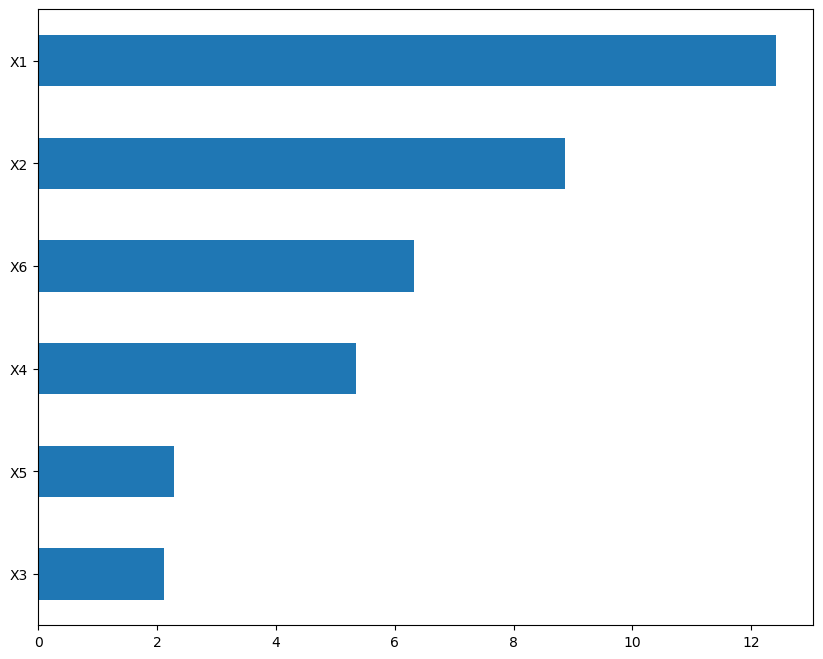

In [21]:
import networkx as nx

# Initialize a dictionary to store feature importances
feature_importances = {}

# 1. Coefficient magnitudes for Perceptron
if 'Perceptron' in best_estimators:
    model = best_estimators['Perceptron']
    if hasattr(model, 'coef_'):
        feature_importances['Perceptron'] = np.abs(model.coef_).flatten()

# 2. Mutual Information for QuadraticDiscriminantAnalysis
if 'QuadraticDiscriminantAnalysis' in best_estimators:
    mutual_info = mutual_info_classif(X_train, y_train, random_state=42)
    feature_importances['QuadraticDiscriminantAnalysis'] = mutual_info

# 3. Centrality Measures for LabelSpreading and LabelPropagation
def calculate_graph_centrality(X, model):
    # Creating a graph where nodes are features, and edges are similarities
    G = nx.Graph()
    G.add_nodes_from(range(X.shape[1]))

    for i in range(X.shape[1]):
        for j in range(i + 1, X.shape[1]):
            if np.corrcoef(X[:, i], X[:, j])[0, 1] > 0.5:  # Adding edges with a threshold correlation
                G.add_edge(i, j, weight=np.corrcoef(X[:, i], X[:, j])[0, 1])

    # Calculate eigenvector centrality
    centrality = nx.eigenvector_centrality_numpy(G)
    centrality_scores = np.array([centrality[i] for i in range(X.shape[1])])
    return centrality_scores

if 'LabelSpreading' in best_estimators:
    centrality_scores = calculate_graph_centrality(X_train.values, best_estimators['LabelSpreading'])
    feature_importances['LabelSpreading'] = centrality_scores

if 'LabelPropagation' in best_estimators:
    centrality_scores = calculate_graph_centrality(X_train.values, best_estimators['LabelPropagation'])
    feature_importances['LabelPropagation'] = centrality_scores

# Convert the dictionary to a DataFrame
feature_importances_df = pd.DataFrame(feature_importances, index=X_train.columns)

# summ across models
feature_importances_df['sum'] = feature_importances_df.abs().sum(axis=1)

# Display the DataFrame
display(feature_importances_df)

# hbarplot
feature_importances_df['sum'].sort_values().plot(kind='barh', figsize=(10, 8))

(7, 4)


C:\Users\Guill\AppData\Local\Temp\ipykernel_94256\3558986178.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_filtered_features_df['sum'] = final_filtered_features_df.iloc[:, :3].abs().sum(axis=1)


,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1^2 X3,0.157588,0.128625,0.128625,0.414837
X2 X4 X5,0.079829,0.151101,0.151101,0.382031
X1 X3 X4,0.062922,0.151955,0.151955,0.366833
X1 X4 X5,0.067758,0.148789,0.148789,0.365336
X1 X3,0.098925,0.131725,0.131725,0.362374
X1 X6^2,0.119850,0.089140,0.089140,0.298131
X2^2 X5,0.124726,0.057528,0.057528,0.239782


<Axes: >

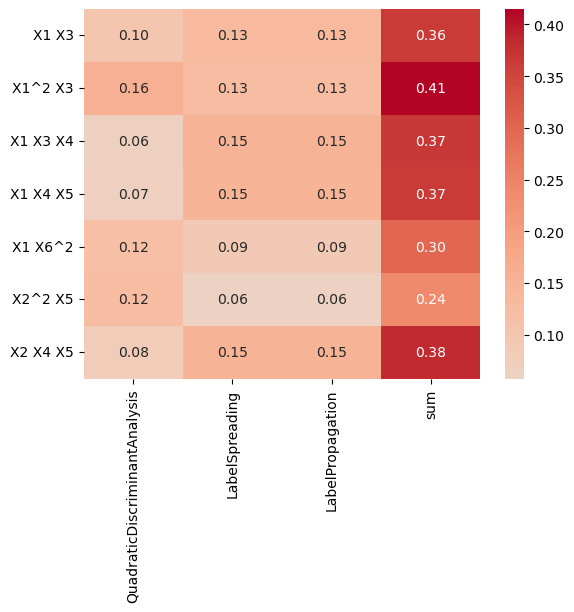

In [22]:
from sklearn.feature_selection import mutual_info_classif
import networkx as nx

# Initialize a dictionary to store feature importances
feature_importances = {}

# 1. Coefficient magnitudes for Perceptron
if 'Perceptron' in best_estimators:
    model = best_estimators['Perceptron']
    if hasattr(model, 'coef_'):
        # Ensure the coefficients length matches the polynomial features
        if model.coef_.shape[1] == len(column_names_poly):
            feature_importances['Perceptron'] = np.abs(model.coef_).flatten()

# 2. Mutual Information for QuadraticDiscriminantAnalysis
if 'QuadraticDiscriminantAnalysis' in best_estimators:
    mutual_info = mutual_info_classif(X_train_poly, y_train, random_state=42)
    feature_importances['QuadraticDiscriminantAnalysis'] = mutual_info

# 3. Centrality Measures for LabelSpreading and LabelPropagation
def calculate_graph_centrality(X_poly):
    # Creating a graph where nodes are features, and edges are similarities
    G = nx.Graph()
    G.add_nodes_from(range(X_poly.shape[1]))

    for i in range(X_poly.shape[1]):
        for j in range(i + 1, X_poly.shape[1]):
            if np.corrcoef(X_poly[:, i], X_poly[:, j])[0, 1] > 0.5:  # Adding edges with a threshold correlation
                G.add_edge(i, j, weight=np.corrcoef(X_poly[:, i], X_poly[:, j])[0, 1])

    # Calculate eigenvector centrality
    centrality = nx.eigenvector_centrality_numpy(G)
    centrality_scores = np.array([centrality[i] for i in range(X_poly.shape[1])])
    return centrality_scores

if 'LabelSpreading' in best_estimators:
    centrality_scores = calculate_graph_centrality(X_train_poly)
    feature_importances['LabelSpreading'] = centrality_scores

if 'LabelPropagation' in best_estimators:
    centrality_scores = calculate_graph_centrality(X_train_poly)
    feature_importances['LabelPropagation'] = centrality_scores

# Convert the dictionary to a DataFrame
# Only include models with feature importances that match the polynomial features
valid_feature_importances = {
    model: importance
    for model, importance in feature_importances.items()
    if len(importance) == len(column_names_poly)
}

feature_importances_df = pd.DataFrame(valid_feature_importances, index=column_names_poly)

# Step 1: Drop features with zero importance across all models
# Keep track of the features that are non-zero in all models
non_zero_mask = pd.Series(True, index=column_names_poly)

for model, importance in feature_importances_df.items():
    non_zero_mask &= (importance >= 0.05)

# Apply the mask to keep only features with non-zero importance across all models
filtered_features_df = feature_importances_df.loc[non_zero_mask]

# Step 2: Filter by 10th percentile
# Calculate the 10th percentile for each model
quantile_thresholds = filtered_features_df.quantile(0.80)

# Keep only features that are above the 10th percentile for at least one model
quantile_mask = pd.Series(False, index=filtered_features_df.index)

for model in filtered_features_df.columns:
    quantile_mask |= (filtered_features_df[model] >= quantile_thresholds[model])

# Apply the mask to keep only features in the top 30% importance for at least one model
final_filtered_features_df = filtered_features_df.loc[quantile_mask]

# Sum across models
final_filtered_features_df['sum'] = final_filtered_features_df.iloc[:, :3].abs().sum(axis=1)

print(final_filtered_features_df.shape)

# Display the DataFrame
_ = final_filtered_features_df.sort_values('sum', ascending=False)
display(_)
# Heatmap
sns.heatmap(final_filtered_features_df, cmap='coolwarm', center=0, annot=True, fmt=".2f")

The analysis highlights **X1** and **X3** as critical questions to include in future surveys, with potential non-linear effects and significant interactions influencing customer happiness.

## Selecting the Questions

1. **Understand the Combinations**: The feature combinations listed represent interactions or selections of different features. For example, `X1^2 X3` suggests an interaction or squared term involving `X1` and `X3`.

2. **Sum Scores**: The sum column indicates the combined importance across all models for each feature set. The higher the sum, the more predictive that feature set is deemed.

3. **Top Feature Combinations**:
   - The highest scoring combination is `X1^2 X3` with a sum of `0.4148`.
   - This suggests that the interaction between `X1` ("My order was delivered on time") and `X3` ("I ordered everything I wanted to order"), particularly with `X1` squared, is the most predictive of customer happiness.

### Insights:

- **Most Important Features**: 
   - **X1 (Order Delivery Time)** and **X3 (Order Completeness)** appear frequently in the top combinations. This suggests that these two features are critical in predicting customer happiness.
   - The importance of `X1^2` suggests that the effect of delivery time on happiness might be non-linear (e.g., being very early or very late could have a different impact).

- **Features That Could Be Removed**:
   - **X6 (App usability)** appears less frequently in top combinations, especially when not interacting with others, which might suggest it’s less critical on its own.
   - **X2 (Contents as Expected)** and **X4 (Price Satisfaction)** also show up but are not consistently top contributors without interactions with other variables.

### Recommendations:

1. **Focus on Key Features**:
   - Keep questions related to **X1 (Order Delivery Time)** and **X3 (Order Completeness)**, as they consistently appear as the most important predictors.
   - Consider retaining **X5 (Courier Satisfaction)** and **X2 (Contents Satisfaction)** as they contribute through interactions.

2. **Potential Removal**:
   - You might consider removing or re-evaluating **X6 (App Usability)** unless it is critical for strategic reasons beyond this model.

In [46]:
final_filtered_features_df

,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1 X3,0.098925,0.131725,0.131725,0.362374
X1^2 X3,0.157588,0.128625,0.128625,0.414837
X1 X3 X4,0.062922,0.151955,0.151955,0.366833
X1 X4 X5,0.067758,0.148789,0.148789,0.365336
X1 X6^2,0.119850,0.089140,0.089140,0.298131
X2^2 X5,0.124726,0.057528,0.057528,0.239782
X2 X4 X5,0.079829,0.151101,0.151101,0.382031


In [47]:
feature_importances_df.assign(sum=lambda x: x.abs().sum(axis=1)).nlargest(10, 'sum')

,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1^2 X3,0.157588,0.128625,0.128625,0.414837
X2 X4 X5,0.079829,0.151101,0.151101,0.382031
X1 X3 X4,0.062922,0.151955,0.151955,0.366833
X1 X4 X5,0.067758,0.148789,0.148789,0.365336
X1 X3,0.098925,0.131725,0.131725,0.362374
X2 X5^2,0.093753,0.118033,0.118033,0.329819
X1 X5,0.086234,0.120330,0.120330,0.326893
X3 X4 X6,0.000000,0.160583,0.160583,0.321165
X2 X3 X5,0.000000,0.157223,0.157223,0.314447
X4 X5 X6,0.005952,0.153607,0.153607,0.313165


# Store transformations

In [45]:
# add the target to the data df_train_poly
df_selected = df_train_poly[final_filtered_features_df.index].assign(Y = y_train)
df_selected = df_test_poly[final_filtered_features_df.index].assign(Y = y_test)

# Export the feature engeneered data to parquet
df_selected.to_parquet('../data/clean/train.parquet')
df_selected.to_parquet('../data/clean/test.parquet')